In [1]:
import dpkt # librería para procesar paquetes de red
import socket

def process_pcap(file_name):
    packets = []
    with open(file_name, 'rb') as f:
        pcap = dpkt.pcap.Reader(f)
        for ts, buf in pcap:
            eth = dpkt.ethernet.Ethernet(buf)
            packet_info = {
                'File': file_name,
                'Time': ts,
                'Source': ':'.join(f"{b:02x}" for b in eth.src),
                'Destination': ':'.join(f"{b:02x}" for b in eth.dst),
                'Protocol': eth.data.__class__.__name__, #__name__ if hasattr(eth.data, 'data')
                #else eth.data.hex(),
                'Length': len(buf),
                'Info':  getattr(eth.data, 'summary', None),
            }
            packets.append(packet_info)
    return packets

# Ejemplo de uso
file_names = ['h1-traffic.pcap', 'h2-traffic.pcap']
combined_packets = []
for file_name in file_names:
    try:
        packets = process_pcap(file_name)
        combined_packets.extend(packets)
    except Exception as e:
        print(f"Error al procesar el archivo {file_name}: {str(e)}")

# Mostrar los primeros 5 paquetes para verificar
for idx, packet in enumerate(combined_packets[:26], 1):
    print(f"Paquete {idx}:")
    print(f"   File:        {packet['File']}")
    print(f"   Time:        {packet['Time']}")
    print(f"   Source:      {packet['Source']}")
    print(f"   Destination: {packet['Destination']}")
    print(f"   Protocol:    {packet['Protocol']}")
    print(f"   Length:      {packet['Length']}")
    print(f"   Info:        {packet['Info']}")
    print()  # línea en blanco entre paquetes



Paquete 1:
   File:        h1-traffic.pcap
   Time:        1718847010.587005
   Source:      ce:66:d5:6d:84:6e
   Destination: 33:33:00:00:00:16
   Protocol:    IP6
   Length:      90
   Info:        None

Paquete 2:
   File:        h1-traffic.pcap
   Time:        1718847010.878138
   Source:      a2:4b:5f:db:b8:92
   Destination: 33:33:ff:db:b8:92
   Protocol:    IP6
   Length:      86
   Info:        None

Paquete 3:
   File:        h1-traffic.pcap
   Time:        1718847010.943029
   Source:      5a:d7:bd:21:1c:d2
   Destination: 33:33:ff:21:1c:d2
   Protocol:    IP6
   Length:      86
   Info:        None

Paquete 4:
   File:        h1-traffic.pcap
   Time:        1718847010.983621
   Source:      5a:d7:bd:21:1c:d2
   Destination: 33:33:00:00:00:16
   Protocol:    IP6
   Length:      90
   Info:        None

Paquete 5:
   File:        h1-traffic.pcap
   Time:        1718847011.003485
   Source:      ce:66:d5:6d:84:6e
   Destination: 33:33:ff:6d:84:6e
   Protocol:    IP6
   Length: 

In [2]:
import pyshark # librería para analizar archivos pcap
import pandas as pd # librería para análisis de datos
import nest_asyncio # librería para permitir el uso de asyncio en entornos no asincrónicos
nest_asyncio.apply() # Permitir el uso de asyncio en entornos no asincrónicos



def format_mac_address(mac):
    # Función para formatear la dirección MAC
    if mac is None:
        return None
    # Verificar si ya es una cadena y no una secuencia de bytes
    if isinstance(mac, str):
        return mac  # Devolver tal cual si ya es una cadena
    return ':'.join(f"{b:02x}" for b in mac)

def load_features_from_pcap(file_name):
    cap = pyshark.FileCapture(file_name)
    data = []
    for pkt in cap:
        try:
            # Usar el campo 'eth.src' y 'eth.dst' directamente si están disponibles
            src_mac = format_mac_address(pkt.eth.src)
            dst_mac = format_mac_address(pkt.eth.dst)
            protocol = pkt.highest_layer  # Usar highest_layer en lugar de transport_layer para obtener el protocolo
            data.append([src_mac, dst_mac, protocol])
        except AttributeError:
            pass  # Ignorar paquetes sin atributos de MAC válidos
    cap.close()

    return pd.DataFrame(data, columns=['Source', 'Destination', 'Protocol'])

# Función para mostrar datos en formato de tabla con formato específico y rango específico
def mostrar_datos_en_formato(data, desde, hasta):
    if data.empty:
        print("No hay datos para mostrar.")
    else:
        # Imprimir encabezados
        print(f"{'Source':<18} {'Destination':<18} Protocol")
        print("="*50)
        # Imprimir datos en el rango especificado
        for i, row in data.iloc[desde-1:hasta].iterrows():
            print(f"{row['Source']:<18} {row['Destination']:<18} {row['Protocol']}")

# Cargar características desde los archivos pcap
data_h1 = load_features_from_pcap('h1-traffic.pcap')
data_h2 = load_features_from_pcap('h2-traffic.pcap')

# Definir el rango de filas a mostrar
desde = 25
hasta = 30

# Mostrar el rango especificado en formato de tabla
print(f"Datos cargados desde h1-traffic.pcap (filas {desde} a {hasta}):")
mostrar_datos_en_formato(data_h1, desde, hasta)

print(f"\nDatos cargados desde h2-traffic.pcap (filas {desde} a {hasta}):")
mostrar_datos_en_formato(data_h2, desde, hasta)



Datos cargados desde h1-traffic.pcap (filas 25 a 30):
Source             Destination        Protocol
a2:4b:5f:db:b8:92  ce:66:d5:6d:84:6e  ARP
ce:66:d5:6d:84:6e  a2:4b:5f:db:b8:92  ARP
a2:4b:5f:db:b8:92  33:33:00:00:00:02  ICMPV6
5a:d7:bd:21:1c:d2  33:33:00:00:00:02  ICMPV6
ce:66:d5:6d:84:6e  a2:4b:5f:db:b8:92  ICMP
a2:4b:5f:db:b8:92  ce:66:d5:6d:84:6e  ICMP

Datos cargados desde h2-traffic.pcap (filas 25 a 30):
Source             Destination        Protocol
ce:66:d5:6d:84:6e  a2:4b:5f:db:b8:92  ARP
a2:4b:5f:db:b8:92  33:33:00:00:00:02  ICMPV6
86:4f:2b:ac:d2:1e  33:33:00:00:00:02  ICMPV6
ce:66:d5:6d:84:6e  a2:4b:5f:db:b8:92  ICMP
a2:4b:5f:db:b8:92  ce:66:d5:6d:84:6e  ICMP
ce:66:d5:6d:84:6e  33:33:00:00:00:02  ICMPV6


In [3]:
import pyshark # librería para analizar archivos pcap
import pandas as pd # librería para análisis de datos

def format_mac_address(mac):
    if mac is None:
        return None
    if isinstance(mac, str):
        return mac
    return ':'.join(f"{b:02x}" for b in mac)

def load_features_from_pcap(file_name):
    cap = pyshark.FileCapture(file_name)
    data = []
    for pkt in cap:
        try:
            src_mac = format_mac_address(pkt.eth.src)
            dst_mac = format_mac_address(pkt.eth.dst)
            protocol = pkt.highest_layer
            length = int(pkt.length)
            duration = float(pkt.frame_info.time_delta)
            data.append([src_mac, dst_mac, protocol, length, duration])
        except AttributeError:
            pass
    cap.close()
    return pd.DataFrame(data, columns=['Source', 'Destination', 'Protocol', 'Length', 'Duration'])

def format_duration(duration):
    # Función para formatear la duración en segundos completos
    return f"{duration:.6f}"  # Mostrar la duración con 6 decimales

def mostrar_datos_en_formato(data, desde, hasta, etiquetas):
    if data.empty:
        print("No hay datos para mostrar.")
    else:
        print(f"{'Source':<18} {'Destination':<18} Protocol {'Length':<8} {'Duration (s)':<15} {'Label':<8}")
        print("="*90)
        for i, (index, row) in enumerate(data.iloc[desde-1:hasta].iterrows(), start=1):
            label = etiquetas[index]
            duration_seconds = format_duration(row['Duration'])
            print(f"{row['Source']:<18} {row['Destination']:<18} {row['Protocol']:<10} {row['Length']:<8} {duration_seconds:<15} {label}")

data_h1 = load_features_from_pcap('h1-traffic.pcap')
data_h2 = load_features_from_pcap('h2-traffic.pcap')

true_labels_h1 = [0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0]
true_labels_h2 = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]

print("Ejemplo de etiquetas verdaderas para h1-traffic.pcap:")
print(true_labels_h1[:25])

print("\nEjemplo de etiquetas verdaderas para h2-traffic.pcap:")
print(true_labels_h2[:25])

print("\nDatos cargados desde h1-traffic.pcap:")
mostrar_datos_en_formato(data_h1, 20, 25, true_labels_h1)

print("\nDatos cargados desde h2-traffic.pcap:")
mostrar_datos_en_formato(data_h2, 20, 25, true_labels_h2)



Ejemplo de etiquetas verdaderas para h1-traffic.pcap:
[0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0]

Ejemplo de etiquetas verdaderas para h2-traffic.pcap:
[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]

Datos cargados desde h1-traffic.pcap:
Source             Destination        Protocol Length   Duration (s)    Label   
a2:4b:5f:db:b8:92  ce:66:d5:6d:84:6e  ICMP       98       0.000045        0
ce:66:d5:6d:84:6e  a2:4b:5f:db:b8:92  ICMP       98       1.017914        1
a2:4b:5f:db:b8:92  ce:66:d5:6d:84:6e  ICMP       98       0.000035        0
ce:66:d5:6d:84:6e  a2:4b:5f:db:b8:92  ICMP       98       1.038492        0
a2:4b:5f:db:b8:92  ce:66:d5:6d:84:6e  ICMP       98       0.000038        1
a2:4b:5f:db:b8:92  ce:66:d5:6d:84:6e  ARP        42       0.094680        0

Datos cargados desde h2-traffic.pcap:
Source             Destination        Protocol Length   Duration (s)    Label   
ce:66:d5:6d:84:6e  a2:4b:5f:db:b8:92  ICMP 

In [4]:
import pyshark # librería para analizar archivos pcap
import pandas as pd # librería para análisis de datos
import nest_asyncio # librería para permitir el uso de asyncio en entornos no asincrónicos
nest_asyncio.apply() # Permitir el uso de asyncio en entornos no asincrónicos

def format_mac_address(mac):
    if mac is None:
        return None
    if isinstance(mac, str):
        return mac
    return ':'.join(f"{b:02x}" for b in mac)

def load_features_from_pcap(file_name):
    cap = pyshark.FileCapture(file_name)
    data = []
    packet_count = 0
    byte_count = 0
    connection_set = set()

    for pkt in cap:
        try:
            src_mac = format_mac_address(pkt.eth.src)
            dst_mac = format_mac_address(pkt.eth.dst)
            protocol = pkt.highest_layer
            length = int(pkt.length)
            duration = float(pkt.frame_info.time_delta)
            
            # Calculamos la cantidad de paquetes por segundo
            packet_count += 1
            packets_per_second = packet_count / duration if duration > 0 else 0
            
            # Contamos las conexiones únicas (por ejemplo, basado en direcciones IP)
            connection_set.add((src_mac, dst_mac))
            active_connections = len(connection_set)
            
            # Calculamos el ancho de banda utilizado (en bytes)
            byte_count += length
            bandwidth_usage = byte_count / duration if duration > 0 else 0
            
            data.append([src_mac, dst_mac, protocol, length, duration, packets_per_second, active_connections, bandwidth_usage])
        except AttributeError:
            pass
    
    cap.close()
    return pd.DataFrame(data, columns=['Source', 'Destination', 'Protocol', 'Length', 'Duration', 'PacketsPerSecond', 'ActiveConnections', 'BandwidthUsage'])

# Función para formatear la duración en segundos completos
def format_duration(duration):
    return f"{duration:.6f}"  # Mostrar la duración con 6 decimales

# Función para mostrar los datos en un formato tabular
def mostrar_datos_en_formato(data, desde, hasta, etiquetas):
    if data.empty:
        print("No hay datos para mostrar.")
    else:
        print(f"{'Source':<18} {'Destination':<18} Protocol {'Length':<8} {'Duration (s)':<15} {'Packets/s':<12} {'Active Conns':<14} {'Bandwidth (B/s)':<16} {'Label':<8}")
        print("="*130)
        for i, (index, row) in enumerate(data.iloc[desde-1:hasta].iterrows(), start=1):
            label = etiquetas[index]
            duration_seconds = format_duration(row['Duration'])
            print(f"{row['Source']:<18} {row['Destination']:<18} {row['Protocol']:<10} {row['Length']:<8} {duration_seconds:<15} {row['PacketsPerSecond']:<12.2f} {row['ActiveConnections']:<14} {row['BandwidthUsage']:<16.2f} {label}")

# Ejemplo de uso
data_h1 = load_features_from_pcap('h1-traffic.pcap')
data_h2 = load_features_from_pcap('h2-traffic.pcap')

true_labels_h1 = [0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0]
true_labels_h2 = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]

print("Ejemplo de etiquetas verdaderas para h1-traffic.pcap:")
print(true_labels_h1[:25])

print("\nEjemplo de etiquetas verdaderas para h2-traffic.pcap:")
print(true_labels_h2[:25])

print("\nDatos cargados desde h1-traffic.pcap:")
mostrar_datos_en_formato(data_h1, 20, 25, true_labels_h1)

print("\nDatos cargados desde h2-traffic.pcap:")
mostrar_datos_en_formato(data_h2, 20, 25, true_labels_h2)

#PacketsPerSecond: Cantidad de paquetes por segundo.
#ActiveConnections: Número de conexiones activas únicas observadas.
#BandwidthUsage: Ancho de banda utilizado en bytes por segundo.


Ejemplo de etiquetas verdaderas para h1-traffic.pcap:
[0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0]

Ejemplo de etiquetas verdaderas para h2-traffic.pcap:
[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]

Datos cargados desde h1-traffic.pcap:
Source             Destination        Protocol Length   Duration (s)    Packets/s    Active Conns   Bandwidth (B/s)  Label   
a2:4b:5f:db:b8:92  ce:66:d5:6d:84:6e  ICMP       98       0.000045        444444.44    11             39466666.67      0
ce:66:d5:6d:84:6e  a2:4b:5f:db:b8:92  ICMP       98       1.017914        20.63        11             1841.02          1
a2:4b:5f:db:b8:92  ce:66:d5:6d:84:6e  ICMP       98       0.000035        628571.43    11             56342857.14      0
ce:66:d5:6d:84:6e  a2:4b:5f:db:b8:92  ICMP       98       1.038492        22.15        11             1993.27          0
a2:4b:5f:db:b8:92  ce:66:d5:6d:84:6e  ICMP       98       0.000038        631578.95    11 

In [5]:
true_labels_h1 = [0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0]
true_labels_h2 = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]

# Formatear duración en segundos completos
data_h1['Duration'] = data_h1['Duration'].apply(format_duration)
data_h2['Duration'] = data_h2['Duration'].apply(format_duration)

# Crear DataFrames con los primeros 25 datos y etiquetas
df_h1 = pd.concat([data_h1.head(25), pd.Series(true_labels_h1[:25], name='Label')], axis=1)
df_h2 = pd.concat([data_h2.head(25), pd.Series(true_labels_h2[:25], name='Label')], axis=1)

# Unir ambos DataFrames en uno solo
df_combined = pd.concat([df_h1, df_h2])

# Guardar DataFrame combinado en un archivo CSV
df_combined.to_csv('combined-traffic-labels.csv', index=False)

print("Archivo CSV guardado exitosamente: combined-traffic-labels.csv")


Archivo CSV guardado exitosamente: combined-traffic-labels.csv


In [6]:
import pandas as pd # Para el análisis de datos


# Cargar los datos desde el archivo CSV
file_path = '/tmp/pycharm_project_282/combined-traffic-labels.csv'
df = pd.read_csv(file_path)

# Imprimir las primeras filas para verificar que los datos se han cargado correctamente
print(df.head())


              Source        Destination Protocol  Length  Duration  \
0  ce:66:d5:6d:84:6e  33:33:00:00:00:16   ICMPV6      90  0.000000   
1  a2:4b:5f:db:b8:92  33:33:ff:db:b8:92   ICMPV6      86  0.291133   
2  5a:d7:bd:21:1c:d2  33:33:ff:21:1c:d2   ICMPV6      86  0.064891   
3  5a:d7:bd:21:1c:d2  33:33:00:00:00:16   ICMPV6      90  0.040592   
4  ce:66:d5:6d:84:6e  33:33:ff:6d:84:6e   ICMPV6      86  0.019864   

   PacketsPerSecond  ActiveConnections  BandwidthUsage  Label  
0          0.000000                  1        0.000000      0  
1          6.869712                  2      604.534697      1  
2         46.231373                  3     4037.539875      0  
3         98.541585                  4     8671.659440      1  
4        251.711639                  5    22049.939589      1  


In [7]:


import pandas as pd

# Cargar los datos desde el CSV
df = pd.read_csv('/tmp/pycharm_project_282/combined-traffic-labels.csv')

# Verificar los primeros registros y las columnas disponibles
df.head()


,Source,Destination,Protocol,Length,Duration,PacketsPerSecond,ActiveConnections,BandwidthUsage,Label
0,ce:66:d5:6d:84:6e,33:33:00:00:00:16,ICMPV6,90,0.000000,0.000000,1,0.000000,0
1,a2:4b:5f:db:b8:92,33:33:ff:db:b8:92,ICMPV6,86,0.291133,6.869712,2,604.534697,1
2,5a:d7:bd:21:1c:d2,33:33:ff:21:1c:d2,ICMPV6,86,0.064891,46.231373,3,4037.539875,0
3,5a:d7:bd:21:1c:d2,33:33:00:00:00:16,ICMPV6,90,0.040592,98.541585,4,8671.659440,1
4,ce:66:d5:6d:84:6e,33:33:ff:6d:84:6e,ICMPV6,86,0.019864,251.711639,5,22049.939589,1


In [8]:
#Deteccion de anomalias

import pandas as pd
from sklearn.model_selection import train_test_split # librería para dividir los datos en entrenamiento y prueba
from sklearn.preprocessing import OneHotEncoder # librería para codificar características categóricas en numéricas

# Cargar los datos desde el CSV
df = pd.read_csv('/tmp/pycharm_project_282/combined-traffic-labels.csv')

# Seleccionar las características y la etiqueta
X = df[['Protocol', 'Length', 'Duration', 'PacketsPerSecond', 'ActiveConnections', 'BandwidthUsage']]
y = df['Label']

# Codificar la característica 'Protocol' usando OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')
X_encoded = encoder.fit_transform(X[['Protocol']])

# Obtener los nombres de las características codificadas
encoded_feature_names = encoder.get_feature_names_out(['Protocol'])

# Convertir a DataFrame y unir con las otras características
X_encoded_df = pd.DataFrame(X_encoded.toarray(), columns=encoded_feature_names)
X = pd.concat([X.drop(columns=['Protocol']), X_encoded_df], axis=1)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




In [9]:
#Insolation Forest (Bosque de Aislamiento)
#sirve para detectar anomalías en los datos, es decir, puntos que son significativamente diferentes del resto de los datos.
#Es un algoritmo de aprendizaje no supervisado que se basa en la construcción de múltiples árboles de decisión durante el entrenamiento.

from sklearn.ensemble import IsolationForest # librería para Isolation Forest
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score # librería para métricas de evaluación de clasificación de datos
import time # librería para medir el tiempo de ejecución

# Crear y ajustar el modelo Isolation Forest
iforest = IsolationForest(random_state=42)

# Medir el tiempo de entrenamiento
start_training_time = time.time()
iforest.fit(X_train)
training_timei = time.time() - start_training_time

# Medir el tiempo de ejecución para las predicciones
start_execution_time = time.time()
iforest_predictions = iforest.predict(X_test)
execution_timei = time.time() - start_execution_time

# Convertir las predicciones a 0 y 1 para calcular las métricas de evaluación
# Isolation Forest predice -1 para anomalías y 1 para normales
iforest_predictions = [0 if x == -1 else 1 for x in iforest_predictions]

# Calcular las métricas de evaluación
precisioni = precision_score(y_test, iforest_predictions)
recalli = recall_score(y_test, iforest_predictions)
f1i = f1_score(y_test, iforest_predictions)
accuracyi = accuracy_score(y_test, iforest_predictions)

print("Isolation Forest:")
print(f"Precisión: {precisioni:.2f}")
print(f"Recall: {recalli:.2f}")
print(f"F1-score: {f1i:.2f}")
print(f"Exactitud (Accuracy): {accuracyi:.2f}")
print(f"Tiempo de ejecución de Isolation Forest: {execution_timei:.2f} segundos")
print(f"Tiempo de entrenamiento de Isolation Forest: {training_timei:.2f} segundos")


Isolation Forest:
Precisión: 0.75
Recall: 0.60
F1-score: 0.67
Exactitud (Accuracy): 0.70
Tiempo de ejecución de Isolation Forest: 0.01 segundos
Tiempo de entrenamiento de Isolation Forest: 0.26 segundos


In [10]:
import pandas as pd
import time
import psutil
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Cargar los datos desde el CSV
df = pd.read_csv('/tmp/pycharm_project_282/combined-traffic-labels.csv')

# Seleccionar las características y la etiqueta
X = df[['Protocol', 'Length', 'Duration', 'PacketsPerSecond', 'ActiveConnections', 'BandwidthUsage']]
y = df['Label']

# Codificar la característica 'Protocol' usando OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')
X_encoded = encoder.fit_transform(X[['Protocol']])

# Obtener los nombres de las características codificadas
encoded_feature_names = encoder.get_feature_names_out(['Protocol'])

# Convertir a DataFrame y unir con las otras características
X_encoded_df = pd.DataFrame(X_encoded.toarray(), columns=encoded_feature_names)
X = pd.concat([X.drop(columns=['Protocol']), X_encoded_df], axis=1)

# Definir fracciones del conjunto de datos
dataset_fractions = [0.2, 0.5, 0.8, 1.0]

# Lista para almacenar los resultados de capacidad
results = []

for fraction in dataset_fractions:
    if fraction == 1.0:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    else:
        # Crear un subconjunto del conjunto de datos original
        X_subset, _, y_subset, _ = train_test_split(X, y, train_size=fraction, stratify=y, random_state=42)

        # Dividir el subconjunto en datos de entrenamiento y prueba
        X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)
    
    # Crear y ajustar el modelo Isolation Forest
    iforest = IsolationForest(random_state=42)
    
    # Medir el tiempo de entrenamiento y uso de recursos
    start_training_time = time.time()
    iforest.fit(X_train)
    training_timei = time.time() - start_training_time
    
    # Medir el tiempo de ejecución para las predicciones y uso de recursos
    start_execution_time = time.time()
    iforest_predictions = iforest.predict(X_test)
    execution_timei = time.time() - start_execution_time
    
    # Convertir las predicciones a 0 y 1 para calcular las métricas de evaluación
    iforest_predictions = [0 if x == -1 else 1 for x in iforest_predictions]
    
    # Calcular las métricas de evaluación
    precisioni = precision_score(y_test, iforest_predictions)
    recalli = recall_score(y_test, iforest_predictions)
    f1i = f1_score(y_test, iforest_predictions)
    accuracyi = accuracy_score(y_test, iforest_predictions)
    
    # Medir uso de CPU y memoria
    cpu_usage = psutil.cpu_percent(interval=1)
    memory_info = psutil.Process(os.getpid()).memory_info()
    
    results.append({
        "fraction": fraction,
        "precision": precisioni,
        "recall": recalli,
        "f1_score": f1i,
        "accuracy": accuracyi,
        "training_time": training_timei,
        "execution_time": execution_timei,
        "cpu_usage": cpu_usage,
        "memory_usage_rss": memory_info.rss / 1024 ** 2,
        "memory_usage_vms": memory_info.vms / 1024 ** 2
    })

# Evaluación de la capacidad del algoritmo en diferentes escenarios
datasets = {
    "original": (X, y)
}

capability_results = []

for name, (X, y) in datasets.items():
    # Dividir el conjunto de datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Crear y ajustar el modelo Isolation Forest
    iforest = IsolationForest(random_state=42)
    
    # Medir el tiempo de entrenamiento y uso de recursos
    start_training_time = time.time()
    iforest.fit(X_train)
    training_timei = time.time() - start_training_time
    
    # Medir el tiempo de ejecución para las predicciones y uso de recursos
    start_execution_time = time.time()
    iforest_predictions = iforest.predict(X_test)
    execution_timei = time.time() - start_execution_time
    
    # Convertir las predicciones a 0 y 1 para calcular las métricas de evaluación
    iforest_predictions = [0 if x == -1 else 1 for x in iforest_predictions]
    
    # Calcular las métricas de evaluación
    precisioni = precision_score(y_test, iforest_predictions)
    recalli = recall_score(y_test, iforest_predictions)
    f1i = f1_score(y_test, iforest_predictions)
    accuracyi = accuracy_score(y_test, iforest_predictions)
    
    capability_results.append({
        "dataset_name": name,
        "precision": precisioni,
        "recall": recalli,
        "f1_score": f1i,
        "accuracy": accuracyi,
        "training_time": training_timei,
        "execution_time": execution_timei
    })

# Imprimir resultados combinados de capacidad
print("Evaluación de la Capacidad para Manejar Conjuntos de Datos Grandes:")
for result in results:
    print(f"Fracción del conjunto de datos: {result['fraction']:.2f}")
    print(f"Precisión: {result['precision']:.2f}")
    print(f"Recall: {result['recall']:.2f}")
    print(f"F1-score: {result['f1_score']:.2f}")
    print(f"Exactitud (Accuracy): {result['accuracy']:.2f}")
    print(f"Tiempo de entrenamiento: {result['training_time']:.2f} segundos")
    print(f"Tiempo de ejecución: {result['execution_time']:.2f} segundos")
    print(f"Uso de CPU: {result['cpu_usage']:.2f}%")
    print(f"Uso de Memoria (RSS): {result['memory_usage_rss']:.2f} MB")
    print(f"Uso de Memoria (VMS): {result['memory_usage_vms']:.2f} MB")
    print("\n")

# Imprimir resultados combinados de capacidad del algoritmo en diferentes escenarios
print("Evaluación de la Capacidad del Algoritmo en Diferentes Escenarios:")
for result in capability_results:
    print(f"Conjunto de datos: {result['dataset_name']}")
    print(f"Precisión: {result['precision']:.2f}")
    print(f"Recall: {result['recall']:.2f}")
    print(f"F1-score: {result['f1_score']:.2f}")
    print(f"Exactitud (Accuracy): {result['accuracy']:.2f}")
    print(f"Tiempo de entrenamiento: {result['training_time']:.2f} segundos")
    print(f"Tiempo de ejecución: {result['execution_time']:.2f} segundos")
    print("\n")



Evaluación de la Capacidad para Manejar Conjuntos de Datos Grandes:
Fracción del conjunto de datos: 0.20
Precisión: 0.00
Recall: 0.00
F1-score: 0.00
Exactitud (Accuracy): 0.00
Tiempo de entrenamiento: 0.16 segundos
Tiempo de ejecución: 0.00 segundos
Uso de CPU: 2.20%
Uso de Memoria (RSS): 231.61 MB
Uso de Memoria (VMS): 1101.72 MB


Fracción del conjunto de datos: 0.50
Precisión: 0.50
Recall: 0.50
F1-score: 0.50
Exactitud (Accuracy): 0.60
Tiempo de entrenamiento: 0.55 segundos
Tiempo de ejecución: 0.01 segundos
Uso de CPU: 3.70%
Uso de Memoria (RSS): 231.61 MB
Uso de Memoria (VMS): 1101.72 MB


Fracción del conjunto de datos: 0.80
Precisión: 0.67
Recall: 0.40
F1-score: 0.50
Exactitud (Accuracy): 0.50
Tiempo de entrenamiento: 0.10 segundos
Tiempo de ejecución: 0.00 segundos
Uso de CPU: 2.10%
Uso de Memoria (RSS): 231.61 MB
Uso de Memoria (VMS): 1101.72 MB


Fracción del conjunto de datos: 1.00
Precisión: 0.75
Recall: 0.60
F1-score: 0.67
Exactitud (Accuracy): 0.70
Tiempo de entrenamiento

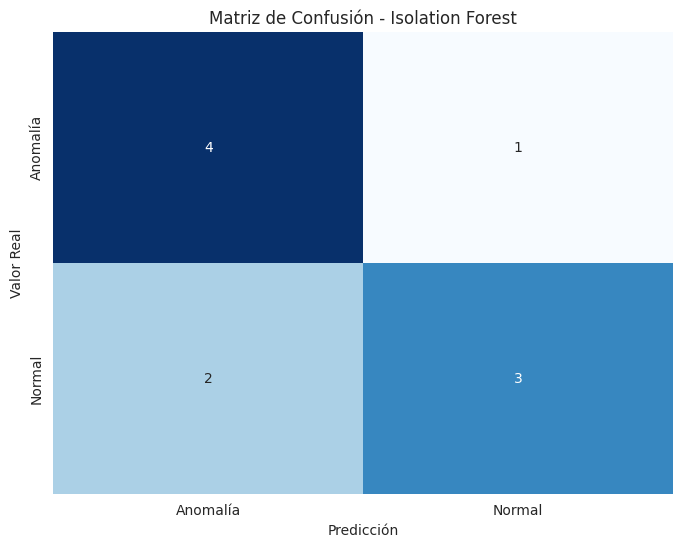

In [11]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Crear y ajustar el modelo Isolation Forest
iforest = IsolationForest(random_state=42)

# Entrenar el modelo
iforest.fit(X_train)

# Realizar predicciones
iforest_predictions = iforest.predict(X_test)
iforest_predictions = [0 if x == -1 else 1 for x in iforest_predictions]

# Calcular la matriz de confusión
cm_iforest = confusion_matrix(y_test, iforest_predictions)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm_iforest, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=['Anomalía', 'Normal'], yticklabels=['Anomalía', 'Normal'])
plt.title('Matriz de Confusión - Isolation Forest')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

#Hay 4 anomalia que el modelo identifico correctamente
#El modelo cometió un error al clasificar 1 instancia que era anomalía como normal
#El modelo cometió un error al no detectar 2 instancias que eran normales y las clasificó como anomalías
#El modelo clasificó correctamente 3 instancias como anomalías


In [12]:
#SVM (Máquina de Vectores de Soporte)
#sirve para clasificar datos en dos categorías, pero también puede ser utilizada para detectar anomalías en datos no etiquetados,
#es decir, datos que no tienen una etiqueta de clase asociada. En este caso, la SVM se entrena para encontrar un límite de decisión
#que separe los datos normales de los datos anómalos en un espacio de alta dimensión.
#es un algoritmo de aprendizaje supervisado que se puede utilizar para clasificación y regresión.

from sklearn.svm import OneClassSVM # librería para One-Class SVM
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score # librería para métricas de evaluación de clasificación de datos
import time # librería para medir el tiempo de ejecución
import seaborn as sns
import matplotlib.pyplot as plt

# Crear y ajustar el modelo One-Class SVM
svm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.1)

# Medir el tiempo de entrenamiento
start_training_time = time.time()
svm.fit(X_train)
training_times = time.time() - start_training_time

# Medir el tiempo de ejecución para las predicciones
start_execution_time = time.time()
svm_predictions = svm.predict(X_test)
execution_times = time.time() - start_execution_time

# Convertir las predicciones a 0 y 1 para calcular las métricas de evaluación
# One-Class SVM predice -1 para anomalías y 1 para normales
svm_predictions_binary = [0 if x == -1 else 1 for x in svm_predictions]

# Calcular las métricas de evaluación
precisions = precision_score(y_test, svm_predictions_binary)
recalls = recall_score(y_test, svm_predictions_binary) 
f1s = f1_score(y_test, svm_predictions_binary)
accuracys = accuracy_score(y_test, svm_predictions_binary)

print("One-Class SVM:")
print(f"Precisión: {precisions:.2f}")
print(f"Recall: {recalls:.2f}")
print(f"F1-score: {f1s:.2f}")
print(f"Exactitud (Accuracy): {accuracys:.2f}")
print(f"Tiempo de ejecución de One-Class SVM: {execution_times:.2f} segundos")
print(f"Tiempo de entrenamiento de One-Class SVM: {training_times:.2f} segundos")



One-Class SVM:
Precisión: 0.50
Recall: 0.80
F1-score: 0.62
Exactitud (Accuracy): 0.50
Tiempo de ejecución de One-Class SVM: 0.00 segundos
Tiempo de entrenamiento de One-Class SVM: 0.00 segundos


In [13]:
import pandas as pd
import time
import psutil
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Cargar los datos desde el CSV
df = pd.read_csv('/tmp/pycharm_project_282/combined-traffic-labels.csv')

# Seleccionar las características y la etiqueta
X = df[['Protocol', 'Length', 'Duration', 'PacketsPerSecond', 'ActiveConnections', 'BandwidthUsage']]
y = df['Label']

# Codificar la característica 'Protocol' usando OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')
X_encoded = encoder.fit_transform(X[['Protocol']])

# Obtener los nombres de las características codificadas
encoded_feature_names = encoder.get_feature_names_out(['Protocol'])

# Convertir a DataFrame y unir con las otras características
X_encoded_df = pd.DataFrame(X_encoded.toarray(), columns=encoded_feature_names)
X = pd.concat([X.drop(columns=['Protocol']), X_encoded_df], axis=1)

# Definir fracciones del conjunto de datos
dataset_fractions = [0.2, 0.5, 0.8, 1.0]

# Lista para almacenar los resultados de capacidad
results = []

for fraction in dataset_fractions:
    if fraction == 1.0:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    else:
        # Crear un subconjunto del conjunto de datos original
        X_subset, _, y_subset, _ = train_test_split(X, y, train_size=fraction, stratify=y, random_state=42)

        # Dividir el subconjunto en datos de entrenamiento y prueba
        X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)
    
    # Crear y ajustar el modelo One-Class SVM
    svm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.1)  # Ajusta el parámetro nu según sea necesario
    
    # Medir el tiempo de entrenamiento
    start_training_time = time.time()
    svm.fit(X_train)
    training_time = time.time() - start_training_time
    
    # Medir el tiempo de ejecución para las predicciones
    start_execution_time = time.time()
    svm_predictions = svm.predict(X_test)
    execution_time = time.time() - start_execution_time
    
    # Convertir las predicciones a 0 y 1 para calcular las métricas de evaluación
    svm_predictions_binary = [0 if x == -1 else 1 for x in svm_predictions]
    
    # Calcular las métricas de evaluación
    precision = precision_score(y_test, svm_predictions_binary, zero_division=0)
    recall = recall_score(y_test, svm_predictions_binary)
    f1 = f1_score(y_test, svm_predictions_binary)
    accuracy = accuracy_score(y_test, svm_predictions_binary)
    
    # Medir uso de CPU y memoria
    cpu_usage = psutil.cpu_percent(interval=1)
    memory_info = psutil.Process(os.getpid()).memory_info()
    
    results.append({
        "fraction": fraction,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "accuracy": accuracy,
        "training_time": training_time,
        "execution_time": execution_time,
        "cpu_usage": cpu_usage,
        "memory_usage_rss": memory_info.rss / 1024 ** 2,
        "memory_usage_vms": memory_info.vms / 1024 ** 2
    })

# Imprimir resultados de capacidad para manejar conjuntos de datos grandes
print("Evaluación de la Capacidad para Manejar Conjuntos de Datos Grandes:")
for result in results:
    print(f"Fracción del conjunto de datos: {result['fraction']:.2f}")
    print(f"Precisión: {result['precision']:.2f}")
    print(f"Recall: {result['recall']:.2f}")
    print(f"F1-score: {result['f1_score']:.2f}")
    print(f"Exactitud (Accuracy): {result['accuracy']:.2f}")
    print(f"Tiempo de entrenamiento: {result['training_time']:.2f} segundos")
    print(f"Tiempo de ejecución: {result['execution_time']:.2f} segundos")
    print(f"Uso de CPU: {result['cpu_usage']:.2f}%")
    print(f"Uso de Memoria (RSS): {result['memory_usage_rss']:.2f} MB")
    print(f"Uso de Memoria (VMS): {result['memory_usage_vms']:.2f} MB")
    print("\n")

# Evaluación de la capacidad del algoritmo en diferentes escenarios
datasets = {
    "original": (X, y)
}

capability_results = []

for name, (X, y) in datasets.items():
    # Dividir el conjunto de datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Crear y ajustar el modelo One-Class SVM
    svm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.1)  # Ajusta el parámetro nu según sea necesario
    
    # Medir el tiempo de entrenamiento
    start_training_time = time.time()
    svm.fit(X_train)
    training_time = time.time() - start_training_time
    
    # Medir el tiempo de ejecución para las predicciones
    start_execution_time = time.time()
    svm_predictions = svm.predict(X_test)
    execution_time = time.time() - start_execution_time
    
    # Convertir las predicciones a 0 y 1 para calcular las métricas de evaluación
    svm_predictions_binary = [0 if x == -1 else 1 for x in svm_predictions]
    
    # Calcular las métricas de evaluación
    precision = precision_score(y_test, svm_predictions_binary, zero_division=0)
    recall = recall_score(y_test, svm_predictions_binary)
    f1 = f1_score(y_test, svm_predictions_binary)
    accuracy = accuracy_score(y_test, svm_predictions_binary)
    
    capability_results.append({
        "dataset_name": name,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "accuracy": accuracy,
        "training_time": training_time,
        "execution_time": execution_time
    })

# Imprimir resultados combinados de capacidad del algoritmo en diferentes escenarios
print("Evaluación de la Capacidad del Algoritmo en Diferentes Escenarios:")
for result in capability_results:
    print(f"Conjunto de datos: {result['dataset_name']}")
    print(f"Precisión: {result['precision']:.2f}")
    print(f"Recall: {result['recall']:.2f}")
    print(f"F1-score: {result['f1_score']:.2f}")
    print(f"Exactitud (Accuracy): {result['accuracy']:.2f}")
    print(f"Tiempo de entrenamiento: {result['training_time']:.2f} segundos")
    print(f"Tiempo de ejecución: {result['execution_time']:.2f} segundos")
    print("\n")


Evaluación de la Capacidad para Manejar Conjuntos de Datos Grandes:
Fracción del conjunto de datos: 0.20
Precisión: 0.00
Recall: 0.00
F1-score: 0.00
Exactitud (Accuracy): 0.50
Tiempo de entrenamiento: 0.00 segundos
Tiempo de ejecución: 0.01 segundos
Uso de CPU: 3.80%
Uso de Memoria (RSS): 241.04 MB
Uso de Memoria (VMS): 1140.80 MB


Fracción del conjunto de datos: 0.50
Precisión: 0.40
Recall: 1.00
F1-score: 0.57
Exactitud (Accuracy): 0.40
Tiempo de entrenamiento: 0.00 segundos
Tiempo de ejecución: 0.00 segundos
Uso de CPU: 2.70%
Uso de Memoria (RSS): 241.04 MB
Uso de Memoria (VMS): 1140.80 MB


Fracción del conjunto de datos: 0.80
Precisión: 0.50
Recall: 0.60
F1-score: 0.55
Exactitud (Accuracy): 0.38
Tiempo de entrenamiento: 0.00 segundos
Tiempo de ejecución: 0.00 segundos
Uso de CPU: 1.60%
Uso de Memoria (RSS): 241.04 MB
Uso de Memoria (VMS): 1140.80 MB


Fracción del conjunto de datos: 1.00
Precisión: 0.50
Recall: 0.80
F1-score: 0.62
Exactitud (Accuracy): 0.50
Tiempo de entrenamiento

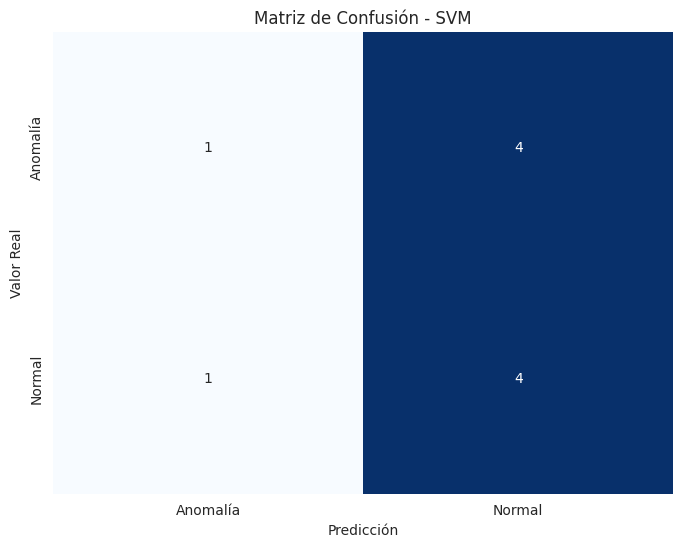

In [14]:
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, svm_predictions_binary)

# Visualizar la matriz de confusión como un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=['Anomalía', 'Normal'], yticklabels=['Anomalía', 'Normal'])
plt.title('Matriz de Confusión - SVM')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()


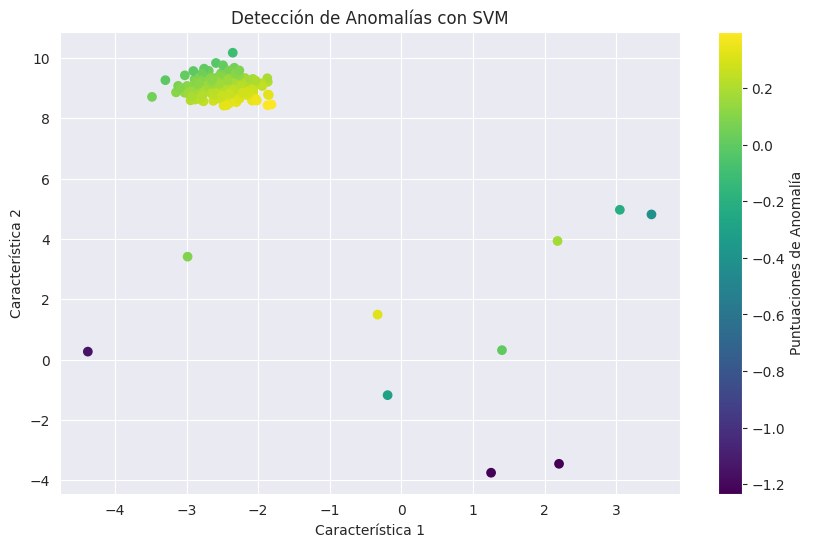

In [15]:
from sklearn.datasets import make_blobs  # librería para generar datos sintéticos
from sklearn.svm import OneClassSVM # librería para One-Class SVM
import matplotlib.pyplot as plt # librería para graficar datos
import numpy as np # librería para operaciones numéricas

# Generar datos sintéticos para demostración
X, _ = make_blobs(n_samples=200, centers=1, cluster_std=0.3, random_state=42)

# Introducir algunas anomalías
outliers = np.random.uniform(low=-5, high=5, size=(10, 2))
X = np.vstack([X, outliers])

# Ajustar el modelo One-Class SVM
svm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)
svm.fit(X)

# Obtener las puntuaciones de decisión/anomalía
svm_scores = svm.decision_function(X)

# Graficar las puntuaciones de anomalía
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=svm_scores, cmap='viridis')
plt.colorbar(label='Puntuaciones de Anomalía')
plt.title('Detección de Anomalías con SVM')
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.grid(True)
plt.show()

#Los puntos más oscuros en el gráfico (colores más fríos en la barra de colores) representan las anomalías detectadas por el SVM, ya que tienen puntuaciones de anomalía más negativas.
#Los puntos más claros (colores más cálidos) son considerados menos anómalos según el modelo.


In [15]:
import pandas as pd

# Cargar los datos desde el archivo CSV
file_path = '/tmp/pycharm_project_282/combined-traffic-labels.csv'  
df = pd.read_csv(file_path)

# Mostrar las primeras filas para entender la estructura de los datos
print(df.head(7))

# Información general sobre el dataset
print(df.info())

# Estadísticas descriptivas básicas
print(df.describe())


              Source        Destination Protocol  Length  Duration  \
0  ce:66:d5:6d:84:6e  33:33:00:00:00:16   ICMPV6      90  0.000000   
1  a2:4b:5f:db:b8:92  33:33:ff:db:b8:92   ICMPV6      86  0.291133   
2  5a:d7:bd:21:1c:d2  33:33:ff:21:1c:d2   ICMPV6      86  0.064891   
3  5a:d7:bd:21:1c:d2  33:33:00:00:00:16   ICMPV6      90  0.040592   
4  ce:66:d5:6d:84:6e  33:33:ff:6d:84:6e   ICMPV6      86  0.019864   
5  ce:66:d5:6d:84:6e  a2:4b:5f:db:b8:92     ICMP      98  0.327313   
6  a2:4b:5f:db:b8:92  ce:66:d5:6d:84:6e     ICMP      98  0.000045   

   PacketsPerSecond  ActiveConnections  BandwidthUsage  Label  
0          0.000000                  1    0.000000e+00      0  
1          6.869712                  2    6.045347e+02      1  
2         46.231373                  3    4.037540e+03      0  
3         98.541585                  4    8.671659e+03      1  
4        251.711639                  5    2.204994e+04      1  
5         18.331078                  6    1.637576e+03 

In [16]:
#LOF Factor de valor atípico local
#algoritmo de detección de anomalías que se basa en el concepto de densidad local
#para detectar las anomalías en los datos.
#es un algoritmo de aprendizaje no supervisado que se puede utilizar para detectar anomalías en datos no etiquetados,
#es decir, datos que no tienen una etiqueta de clase asociada.

from sklearn.neighbors import LocalOutlierFactor # librería para Local Outlier Factor (LOF)
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score # librería para métricas de evaluación de clasificación de datos
import time # librería para medir el tiempo de ejecución
import numpy as np # librería para operaciones numéricas

# Crear y ajustar el modelo Local Outlier Factor (LOF)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)

# Medir el tiempo de entrenamiento
start_training_time = time.time()
lof.fit(X_train)
training_time_lof = time.time() - start_training_time

# Obtener las puntuaciones de anomalía
lof_scores = lof.negative_outlier_factor_

# Definir un umbral para clasificar las anomalías (por ejemplo, el percentil 10)
threshold = np.percentile(lof_scores, 10)

# Predecir anomalías (1 para normal, -1 para anomalía)
lof_predictions = [1 if x >= threshold else -1 for x in lof_scores]

# Convertir las predicciones a 0 y 1 para calcular las métricas de evaluación
# 1 para normales, 0 para anomalías
lof_predictions_binary = [0 if x == -1 else 1 for x in lof_predictions]

# Ajustar las predicciones a la longitud de y_test (si es necesario)
lof_predictions_binary = lof_predictions_binary[:len(y_test)]

# Medir el tiempo de ejecución para las predicciones
start_execution_time = time.time()
# Calcula las métricas de evaluación
precision_lof = precision_score(y_test, lof_predictions_binary)
recall_lof = recall_score(y_test, lof_predictions_binary)
f1_lof = f1_score(y_test, lof_predictions_binary)
accuracy_lof = accuracy_score(y_test, lof_predictions_binary)
execution_time_lof = time.time() - start_execution_time

print("Local Outlier Factor (LOF):")
print(f"Precisión: {precision_lof:.2f}")
print(f"Recall: {recall_lof:.2f}")
print(f"F1-score: {f1_lof:.2f}")
print(f"Exactitud (Accuracy): {accuracy_lof:.2f}")
print(f"Tiempo de ejecución de predicciones de LOF: {execution_time_lof:.2f} segundos")
print(f"Tiempo de entrenamiento de LOF: {training_time_lof:.2f} segundos")

Local Outlier Factor (LOF):
Precisión: 0.56
Recall: 1.00
F1-score: 0.71
Exactitud (Accuracy): 0.60
Tiempo de ejecución de predicciones de LOF: 0.02 segundos
Tiempo de entrenamiento de LOF: 0.03 segundos


In [17]:
import pandas as pd
import time
import psutil
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Cargar los datos desde el CSV
df = pd.read_csv('/tmp/pycharm_project_282/combined-traffic-labels.csv')

# Seleccionar las características y la etiqueta
X = df[['Protocol', 'Length', 'Duration', 'PacketsPerSecond', 'ActiveConnections', 'BandwidthUsage']]
y = df['Label']

# Codificar la característica 'Protocol' usando OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')
X_encoded = encoder.fit_transform(X[['Protocol']])

# Obtener los nombres de las características codificadas
encoded_feature_names = encoder.get_feature_names_out(['Protocol'])

# Convertir a DataFrame y unir con las otras características
X_encoded_df = pd.DataFrame(X_encoded.toarray(), columns=encoded_feature_names)
X = pd.concat([X.drop(columns=['Protocol']), X_encoded_df], axis=1)

# Definir fracciones del conjunto de datos
dataset_fractions = [0.2, 0.5, 0.8, 1.0]

# Lista para almacenar los resultados de capacidad para LOF
results_lof = []

# Lista para almacenar los resultados de capacidad para diferentes escenarios
capability_results = []

# Iterar sobre diferentes fracciones del conjunto de datos
for fraction in dataset_fractions:
    if fraction == 1.0:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    else:
        # Crear un subconjunto del conjunto de datos original
        X_subset, _, y_subset, _ = train_test_split(X, y, train_size=fraction, stratify=y, random_state=42)

        # Dividir el subconjunto en datos de entrenamiento y prueba
        X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)
    
    # Ajustar n_neighbors basado en el tamaño de X_train
    n_neighbors = min(20, len(X_train) - 1)
    
    # Crear y ajustar el modelo Local Outlier Factor (LOF)
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=0.1)

    # Medir el tiempo de entrenamiento de LOF
    start_training_time = time.time()
    lof.fit(X_train)
    training_time_lof = time.time() - start_training_time
    
    # Obtener las puntuaciones de anomalía de LOF
    lof_scores = lof.negative_outlier_factor_
    
    # Definir un umbral para clasificar las anomalías (por ejemplo, el percentil 10)
    threshold = np.percentile(lof_scores, 10)
    
    # Predecir anomalías (1 para normal, -1 para anomalía)
    start_execution_time = time.time()
    lof_predictions = [1 if x >= threshold else -1 for x in lof_scores]
    execution_time = time.time() - start_execution_time
    
    # Convertir las predicciones a 0 y 1 para calcular las métricas de evaluación
    lof_predictions_binary = [0 if x == -1 else 1 for x in lof_predictions]
    
    # Ajustar las predicciones a la longitud de y_test (si es necesario)
    lof_predictions_binary = lof_predictions_binary[:len(y_test)]
    
    # Calcular las métricas de evaluación para LOF
    precision_lof = precision_score(y_test, lof_predictions_binary, zero_division=0)
    recall_lof = recall_score(y_test, lof_predictions_binary)
    f1_lof = f1_score(y_test, lof_predictions_binary)
    accuracy_lof = accuracy_score(y_test, lof_predictions_binary)
    
    # Almacenar los resultados de capacidad para LOF
    results_lof.append({
        "fraction": fraction,
        "precision": precision_lof,
        "recall": recall_lof,
        "f1_score": f1_lof,
        "accuracy": accuracy_lof,
        "training_time": training_time_lof,
        "execution_time": execution_time,
        "cpu_usage": psutil.cpu_percent(interval=1),
        "memory_usage_rss": psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2,
        "memory_usage_vms": psutil.Process(os.getpid()).memory_info().vms / 1024 ** 2
    })

# Imprimir resultados de capacidad para manejar conjuntos de datos grandes (LOF)
print("Evaluación de la Capacidad para Manejar Conjuntos de Datos Grandes (LOF):")
for result in results_lof:
    print(f"Fracción del conjunto de datos: {result['fraction']:.2f}")
    print(f"Precisión: {result['precision']:.2f}")
    print(f"Recall: {result['recall']:.2f}")
    print(f"F1-score: {result['f1_score']:.2f}")
    print(f"Exactitud (Accuracy): {result['accuracy']:.2f}")
    print(f"Tiempo de entrenamiento: {result['training_time']:.2f} segundos")
    print(f"Tiempo de ejecución: {result['execution_time']:.2f} segundos")
    print(f"Uso de CPU: {result['cpu_usage']:.2f}%")
    print(f"Uso de Memoria (RSS): {result['memory_usage_rss']:.2f} MB")
    print(f"Uso de Memoria (VMS): {result['memory_usage_vms']:.2f} MB")
    print("\n")

# Evaluar la capacidad del algoritmo en diferentes escenarios (usando la fracción completa del conjunto de datos)
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size=0.2, random_state=42)

# Ajustar n_neighbors basado en el tamaño de X_train_full
n_neighbors_full = min(20, len(X_train_full) - 1)

# Crear y ajustar el modelo LOF en el escenario completo
lof_full = LocalOutlierFactor(n_neighbors=n_neighbors_full, contamination=0.1)

# Medir el tiempo de entrenamiento en el escenario completo
start_training_time_full = time.time()
lof_full.fit(X_train_full)
training_time_full = time.time() - start_training_time_full

# Obtener las puntuaciones de anomalía para el escenario completo
lof_scores_full = lof_full.negative_outlier_factor_

# Definir un umbral para clasificar las anomalías en el escenario completo (percentil 10)
threshold_full = np.percentile(lof_scores_full, 10)

# Predecir anomalías en el escenario completo (1 para normal, -1 para anomalía)
start_execution_time_full = time.time()
lof_predictions_full = [1 if x >= threshold_full else -1 for x in lof_scores_full]
execution_time_full = time.time() - start_execution_time_full

# Convertir las predicciones a 0 y 1 para calcular las métricas de evaluación
lof_predictions_binary_full = [0 if x == -1 else 1 for x in lof_predictions_full]

# Ajustar las predicciones a la longitud de y_test_full (si es necesario)
lof_predictions_binary_full = lof_predictions_binary_full[:len(y_test_full)]

# Calcular las métricas de evaluación en el escenario completo
precision_full = precision_score(y_test_full, lof_predictions_binary_full, zero_division=0)
recall_full = recall_score(y_test_full, lof_predictions_binary_full)
f1_full = f1_score(y_test_full, lof_predictions_binary_full)
accuracy_full = accuracy_score(y_test_full, lof_predictions_binary_full)

# Almacenar los resultados de capacidad para el escenario completo
capability_results.append({
    "dataset_name": "Original Dataset (Full)",
    "precision": precision_full,
    "recall": recall_full,
    "f1_score": f1_full,
    "accuracy": accuracy_full,
    "training_time": training_time_full,
    "execution_time": execution_time_full,
})

# Imprimir resultados de capacidad del algoritmo en diferentes escenarios
print("Evaluación de la Capacidad del Algoritmo en Diferentes Escenarios:")
for result in capability_results:
    print(f"Conjunto de datos: {result['dataset_name']}")
    print(f"Precisión: {result['precision']:.2f}")
    print(f"Recall: {result['recall']:.2f}")
    print(f"F1-score: {result['f1_score']:.2f}")
    print(f"Exactitud (Accuracy): {result['accuracy']:.2f}")
    print(f"Tiempo de entrenamiento: {result['training_time']:.2f} segundos")
    print(f"Tiempo de ejecución: {result['execution_time']:.2f} segundos")
    print("\n")


Evaluación de la Capacidad para Manejar Conjuntos de Datos Grandes (LOF):
Fracción del conjunto de datos: 0.20
Precisión: 0.50
Recall: 1.00
F1-score: 0.67
Exactitud (Accuracy): 0.50
Tiempo de entrenamiento: 0.00 segundos
Tiempo de ejecución: 0.00 segundos
Uso de CPU: 3.60%
Uso de Memoria (RSS): 245.39 MB
Uso de Memoria (VMS): 1245.80 MB


Fracción del conjunto de datos: 0.50
Precisión: 0.40
Recall: 1.00
F1-score: 0.57
Exactitud (Accuracy): 0.40
Tiempo de entrenamiento: 0.01 segundos
Tiempo de ejecución: 0.00 segundos
Uso de CPU: 3.30%
Uso de Memoria (RSS): 245.39 MB
Uso de Memoria (VMS): 1245.80 MB


Fracción del conjunto de datos: 0.80
Precisión: 0.62
Recall: 1.00
F1-score: 0.77
Exactitud (Accuracy): 0.62
Tiempo de entrenamiento: 0.00 segundos
Tiempo de ejecución: 0.00 segundos
Uso de CPU: 2.60%
Uso de Memoria (RSS): 245.39 MB
Uso de Memoria (VMS): 1245.80 MB


Fracción del conjunto de datos: 1.00
Precisión: 0.56
Recall: 1.00
F1-score: 0.71
Exactitud (Accuracy): 0.60
Tiempo de entrena

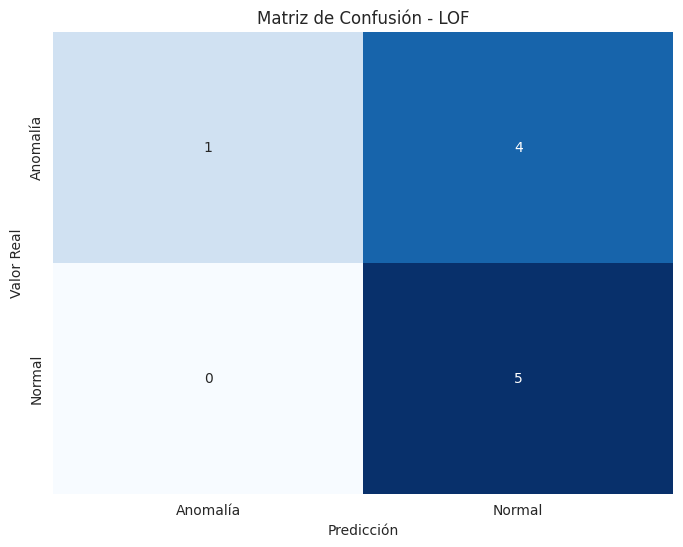

In [18]:
from sklearn.metrics import confusion_matrix # librería para la matriz de confusión
import seaborn as sns # librería para graficar datos con Seaborn (mejora de Matplotlib)
import matplotlib.pyplot as plt # librería para graficar datos con Matplotlib

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, lof_predictions_binary)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=['Anomalía', 'Normal'], yticklabels=['Anomalía', 'Normal'])
plt.title('Matriz de Confusión - LOF')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

#Hay una anomalia que el modelo identifico correctamente
#El modelo no detecto 4 anomalias prediciendola como normal
#El modelo no predijo incorrectamente ninguna instancia normal como anomalia
#El modelo detecto correctamente 5 instancias normales


In [19]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Matriz de decisión (rows: algoritmos, columns: criterios)
decision_matrix = np.array([
    [precisioni, recalli, f1i, accuracyi, training_timei, memory_info.rss, memory_info.vms],  # Isolation Forest
    [precision, recall, f1, accuracy, training_time, memory_info.rss, memory_info.vms],  # One-Class SVM
    [precision_lof, recall_lof, f1_lof, accuracy_lof, training_time_lof, memory_info.rss, memory_info.vms]  # LOF
])

# Pesos para cada criterio (ajustados según importancia)
weights = np.array([0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1])  # Ejemplo de pesos ajustados

# Normalizar la matriz de decisión
norm_matrix = decision_matrix / np.sqrt((decision_matrix ** 2).sum(axis=0))

# Ponderar la matriz normalizada
weighted_matrix = norm_matrix * weights

# Identificar las soluciones ideal positiva y negativa
ideal_positive = weighted_matrix.max(axis=0)
ideal_negative = weighted_matrix.min(axis=0)

# Calcular las distancias a las soluciones ideal positiva y negativa
distance_positive = np.sqrt(((weighted_matrix - ideal_positive) ** 2).sum(axis=1))
distance_negative = np.sqrt(((weighted_matrix - ideal_negative) ** 2).sum(axis=1))

# Calcular el puntaje de preferencia
preference_scores = distance_negative / (distance_positive + distance_negative)

# Determinar el mejor algoritmo basado en el puntaje de preferencia
best_algorithm_index = preference_scores.argmax()
algorithms = ['Isolation Forest', 'One-Class SVM', 'LOF']

# Mostrar los resultados
for i, algorithm in enumerate(algorithms):
    print(f"{algorithm}:")
    print(f"  Precisión: {decision_matrix[i, 0]:.2f}")
    print(f"  Recall: {decision_matrix[i, 1]:.2f}")
    print(f"  F1-score: {decision_matrix[i, 2]:.2f}")
    print(f"  Exactitud (Accuracy): {decision_matrix[i, 3]:.2f}")
    print(f"  Tiempo de Entrenamiento: {decision_matrix[i, 4]:.2f} segundos")
    print(f"  Uso de Memoria (RSS): {decision_matrix[i, 5]:.2f} MB")
    print(f"  Uso de Memoria (VMS): {decision_matrix[i, 6]:.2f} MB")
    print(f"  Puntaje de Preferencia: {preference_scores[i]:.4f}")
    print()

print("Puntajes de preferencia:", preference_scores)
print("Mejor algoritmo según TOPSIS:", algorithms[best_algorithm_index])


Isolation Forest:
  Precisión: 0.75
  Recall: 0.60
  F1-score: 0.67
  Exactitud (Accuracy): 0.70
  Tiempo de Entrenamiento: 0.11 segundos
  Uso de Memoria (RSS): 252743680.00 MB
  Uso de Memoria (VMS): 1196220416.00 MB
  Puntaje de Preferencia: 0.6703

One-Class SVM:
  Precisión: 0.50
  Recall: 0.80
  F1-score: 0.62
  Exactitud (Accuracy): 0.50
  Tiempo de Entrenamiento: 0.00 segundos
  Uso de Memoria (RSS): 252743680.00 MB
  Uso de Memoria (VMS): 1196220416.00 MB
  Puntaje de Preferencia: 0.1901

LOF:
  Precisión: 0.56
  Recall: 1.00
  F1-score: 0.71
  Exactitud (Accuracy): 0.60
  Tiempo de Entrenamiento: 0.00 segundos
  Uso de Memoria (RSS): 252743680.00 MB
  Uso de Memoria (VMS): 1196220416.00 MB
  Puntaje de Preferencia: 0.3720

Puntajes de preferencia: [0.67030746 0.19008637 0.37203468]
Mejor algoritmo según TOPSIS: Isolation Forest


In [9]:
import pyshark
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import IsolationForest
import logging
import time

# Configuración de logging
logging.basicConfig(filename='network_monitoring.log', level=logging.INFO, format='%(asctime)s - %(message)s')

# Función para extraer características de un paquete
def extract_features(packet):
    try:
        protocol = packet.transport_layer
        length = int(packet.length)
        src_ip = packet.ip.src
        dst_ip = packet.ip.dst
        src_port = packet[packet.transport_layer].srcport
        dst_port = packet[packet.transport_layer].dstport
        return [protocol, length, src_ip, dst_ip, src_port, dst_port]
    except AttributeError:
        return None

# Capturar tráfico de red en tiempo real y preprocesar los datos
def capture_and_process_data(interface='wlan0', packet_count=100):
    cap = pyshark.LiveCapture(interface=interface)
    data = []
    for packet in cap.sniff_continuously(packet_count=packet_count):
        features = extract_features(packet)
        if features:
            data.append(features)
    df = pd.DataFrame(data, columns=['Protocol', 'Length', 'Source', 'Destination', 'SourcePort', 'DestinationPort'])

    # Codificar la característica 'Protocol'
    encoder = OneHotEncoder(handle_unknown='ignore')
    X_encoded = encoder.fit_transform(df[['Protocol']])
    encoded_feature_names = encoder.get_feature_names_out(['Protocol'])
    X_encoded_df = pd.DataFrame(X_encoded.toarray(), columns=encoded_feature_names)

    # Seleccionar solo características numéricas para escalado
    numerical_features = df[['Length', 'SourcePort', 'DestinationPort']]
    scaler = StandardScaler()
    X_scaled_numerical = scaler.fit_transform(numerical_features)
    X_scaled_numerical_df = pd.DataFrame(X_scaled_numerical, columns=['Length', 'SourcePort', 'DestinationPort'])

    # Combinar características escaladas y codificadas
    X = pd.concat([X_scaled_numerical_df, X_encoded_df], axis=1)

    return X, encoder, scaler, encoded_feature_names  # Devolver encoded_feature_names

# Ajustar el valor de contamination según la naturaleza de tu red
contamination_rate = 0.1  # Ajusta este valor según la frecuencia de anomalías esperadas

# Inicialmente capturamos datos para entrenar el modelo
X_scaled, encoder, scaler, encoded_feature_names = capture_and_process_data()

# Entrenar el modelo Isolation Forest con el parámetro contamination ajustado
iso_forest = IsolationForest(contamination=contamination_rate, random_state=42)
iso_forest.fit(X_scaled)

# Monitorear tráfico de red en tiempo real y detectar anomalías
def monitor_traffic(interface='wlan0', encoded_feature_names=None):
    cap = pyshark.LiveCapture(interface=interface)
    try:
        for packet in cap.sniff_continuously():
            start_time = time.time()
            features = extract_features(packet)
            if features:
                try:
                    df_packet = pd.DataFrame([features], columns=['Protocol', 'Length', 'Source', 'Destination', 'SourcePort', 'DestinationPort'])
                    X_packet_encoded = encoder.transform(df_packet[['Protocol']])
                    X_packet_encoded_df = pd.DataFrame(X_packet_encoded.toarray(), columns=encoded_feature_names)

                    # Seleccionar solo características numéricas para escalado
                    X_packet_numerical = df_packet[['Length', 'SourcePort', 'DestinationPort']]
                    X_packet_scaled_numerical = scaler.transform(X_packet_numerical)
                    X_packet_scaled_numerical_df = pd.DataFrame(X_packet_scaled_numerical, columns=['Length', 'SourcePort', 'DestinationPort'])

                    # Combinar características escaladas y codificadas
                    X_packet = pd.concat([X_packet_scaled_numerical_df, X_packet_encoded_df], axis=1)
                    
                    prediction = iso_forest.predict(X_packet)
                    is_anomaly = prediction[0] == -1

                    # Registrar el resultado en el archivo de log
                    processing_time = time.time() - start_time
                    log_message = f"Paquete {'anómalo' if is_anomaly else 'normal'} detectado: {features}. Tiempo de procesamiento: {processing_time:.4f} segundos."
                    logging.info(log_message)
                    print(log_message)
                except Exception as e:
                    logging.error(f"Error procesando el paquete: {features}. Error: {e}")
            else:
                logging.warning("Paquete sin características útiles.")
    except KeyboardInterrupt:
        print("Monitoreo detenido por el usuario.")
        logging.info("Monitoreo detenido por el usuario.")

# Ejecutar la función de monitoreo de tráfico
monitor_traffic(encoded_feature_names=encoded_feature_names)


Paquete normal detectado: ['TCP', 151, '142.251.132.138', '192.168.1.6', '443', '57414']. Tiempo de procesamiento: 0.0058 segundos.
Paquete normal detectado: ['TCP', 66, '192.168.1.6', '142.251.132.138', '57414', '443']. Tiempo de procesamiento: 0.0060 segundos.
Paquete normal detectado: ['TCP', 105, '142.251.132.138', '192.168.1.6', '443', '57414']. Tiempo de procesamiento: 0.0059 segundos.
Paquete normal detectado: ['TCP', 97, '142.251.132.138', '192.168.1.6', '443', '57414']. Tiempo de procesamiento: 0.0060 segundos.
Paquete normal detectado: ['TCP', 78, '192.168.1.6', '142.251.132.138', '57414', '443']. Tiempo de procesamiento: 0.0057 segundos.
Paquete normal detectado: ['TCP', 66, '192.168.1.6', '142.251.132.138', '57414', '443']. Tiempo de procesamiento: 0.0061 segundos.
Paquete normal detectado: ['TCP', 105, '192.168.1.6', '142.251.132.138', '57414', '443']. Tiempo de procesamiento: 0.0070 segundos.
Paquete normal detectado: ['TCP', 66, '142.251.132.138', '192.168.1.6', '443', '